# Space-Time Event Clustering

In [1]:
%load_ext watermark
%watermark -a 'eli knaap' -v -d -u -p pointpats,geopandas,libpysal

Author: eli knaap

Last updated: 2023-09-25

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pointpats: 2.3.0
geopandas: 0.13.2
libpysal : 4.7.0



A classic tradition in spatial analysis examines the clustering of events in time and space. A set of "events" in this case is a dataset with both a geographic location (i.e. a point with X and Y coordinates) and a temporal location (i.e. a timestamp or some record of *when* something occurred). Events that cluster togther in time and space can often be substantively important across a wide variety of social, behavioral, and natural sciences. For example in epidemiology, a cluster of events may help identify a disease outbreak, but understanding clustering in space-time event data is widely applicable in many fields. Further, the data are often already present in the most useful format. Example research questions and geocoded/timestamped data might include:

**public health & epidemiology**, e.g. to describe outbreaks or help identify inflection points in an epidemic
- infections
- vaccines
- overdoses

**transportation**, e.g. to identify dangerous intersections or high-demand transit locations
- traffic accidents
- taxi hails
- DUI violations

**housing** e.g. to identify transitioning land markets or residential displacement
- development permits
- foreclosures
- evictions

**marketing** e.g. to understand which campaigns do better in which locations
- sales 
- ad clicks
- conversions

**criminology** e.g. to understand inequality in police enforcement or 
- stop and frisk incidents
- burglaries
- firearm sales

**earth & climate science** e.g. to examine impacts of climate change on catastrophic events 
- volcanic eruptions
- earthquakes
- hurricane landfalls

One of the most commonly-used approaches is the [Knox statistic](https://doi.org/10.2307/2985220), first formulated in epidemiology to study disease outbreaks. The Knox statistic looks for clustering of events in space and time using two distance thresholds that define a set of "spatial neighbors" who are nearby in the geographical sense, and a set of "temporal neighbors" who are nearby in time. These thresholds are commonly called *delta* ($\delta$, for distance) and *tau* ($\tau$, for time) respectively.

To use a Knox statistic, we adopt the null hypothesis that events are distributed randomly through space and time, and we look for non-random groups in the data. That is, if we find there are more events than expected within the two thresholds, then there is evidence to reject the null in favor of space-time clustering.

In [2]:
import geopandas as gpd
import pandas as pd
from pointpats import Knox, KnoxLocal, plot_density

## Traffic Collisions in San Diego County

To demonstrate the Knox and KnoxLocal functionality in `pointpats`, we will use the example of traffic collisions in San Diego using an open dataset collected from the CA Highway Patrol

These data contain an extract from <https://iswitrs.chp.ca.gov/Reports/jsp/SampleReports.jsp> from dates 1/1/2001 - 8/1/2023. More information on the dataset including field codes is
available from <https://iswitrs.chp.ca.gov/Reports/jsp/samples/RawData_template.pdf>


In [3]:
sd_collisions = gpd.read_parquet("sd_collisions.parquet")

In [4]:
sd_collisions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 183525 entries, 0 to 183524
Data columns (total 80 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   index                    183525 non-null  int64         
 1   CASE_ID                  183525 non-null  int64         
 2   ACCIDENT_YEAR            183525 non-null  int64         
 3   PROC_DATE                183525 non-null  int64         
 4   JURIS                    183525 non-null  object        
 5   COLLISION_DATE           183525 non-null  datetime64[us]
 6   COLLISION_TIME           183525 non-null  int64         
 7   OFFICER_ID               183424 non-null  object        
 8   REPORTING_DISTRICT       11628 non-null   object        
 9   DAY_OF_WEEK              183525 non-null  int64         
 10  CHP_SHIFT                183525 non-null  int64         
 11  POPULATION               183525 non-null  int64         
 12  CNTY_CIT

<Axes: >

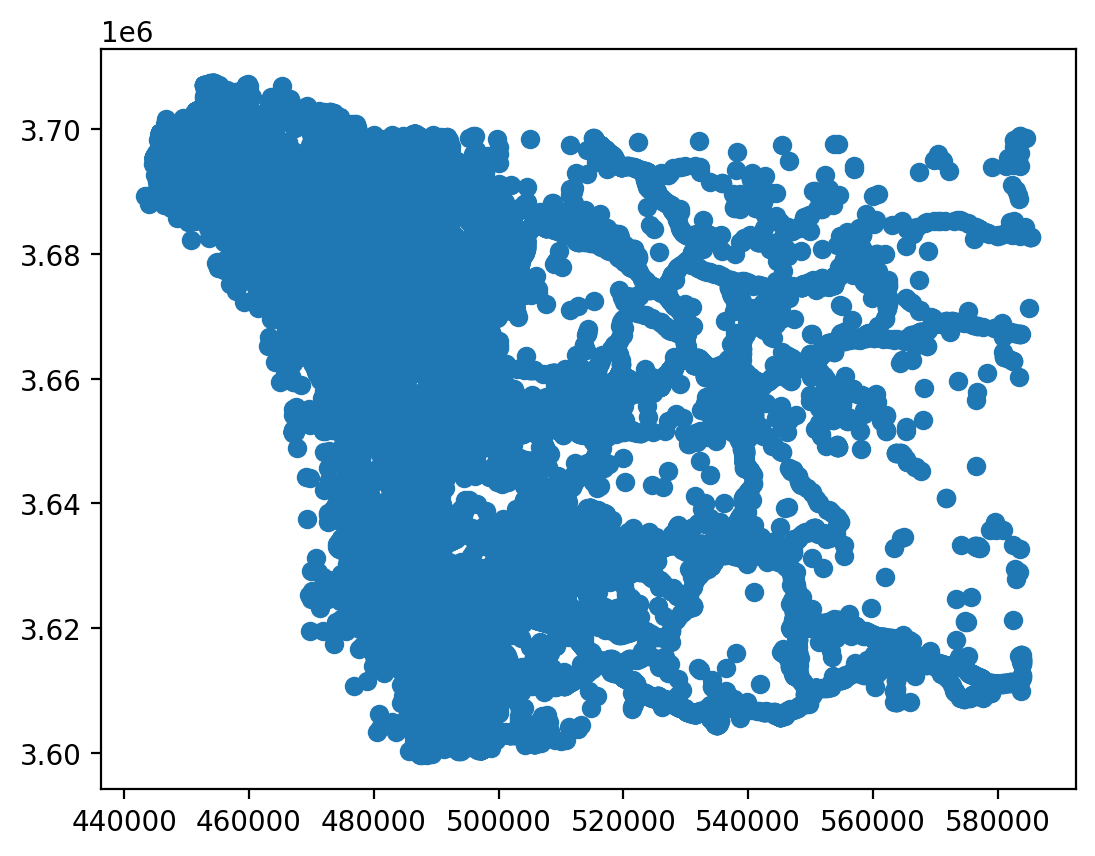

In [5]:
sd_collisions.plot()

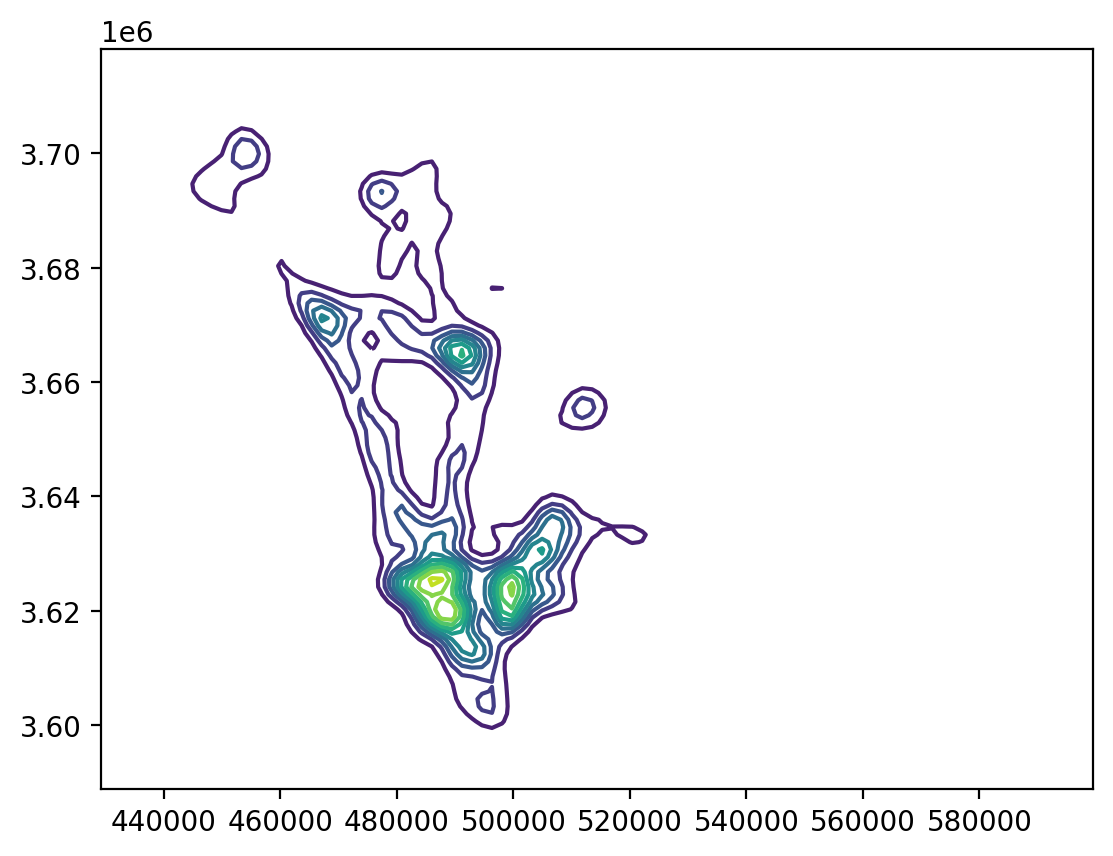

In [6]:
# note you need statsmodels installed to run this line
ax = plot_density(sd_collisions, bandwidth=2000)

In [7]:
ped_collisions = sd_collisions[sd_collisions["PEDESTRIAN_ACCIDENT"] == "Y"]
bike_collisions = sd_collisions[sd_collisions["BICYCLE_ACCIDENT"] == "Y"]

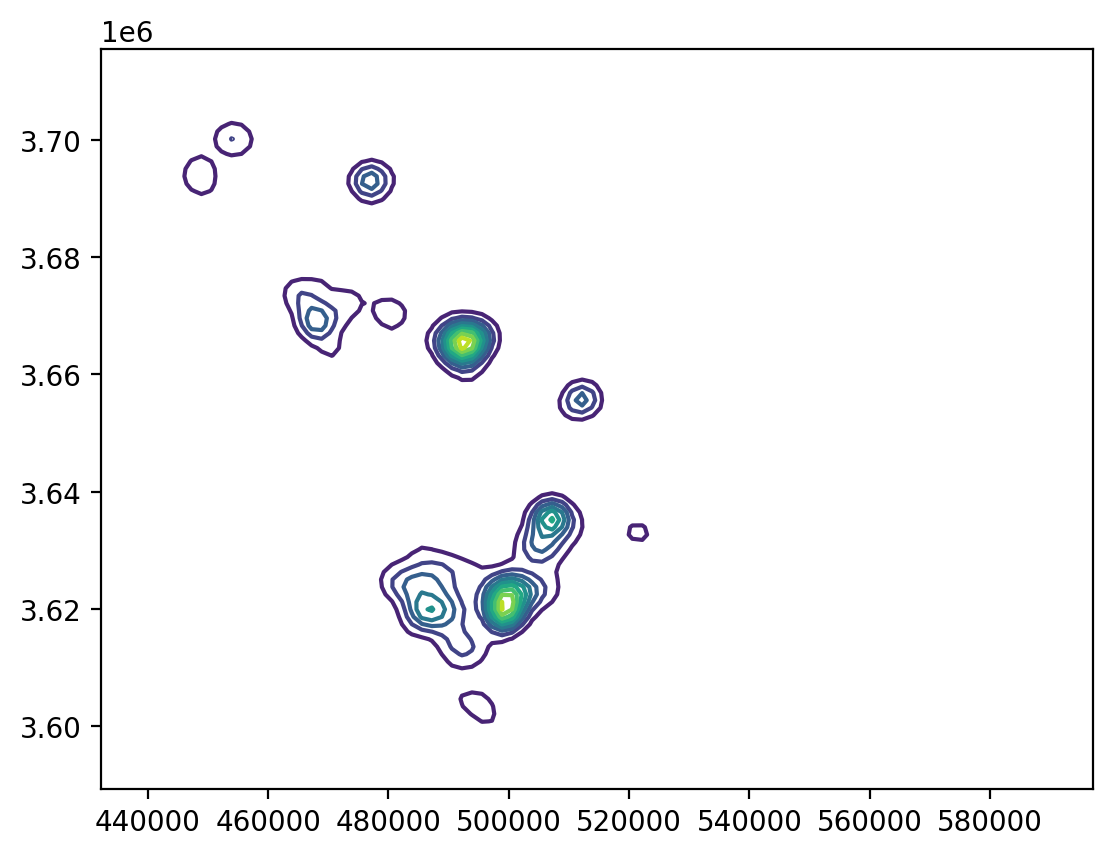

In [8]:
plot_density(ped_collisions, bandwidth=2000)

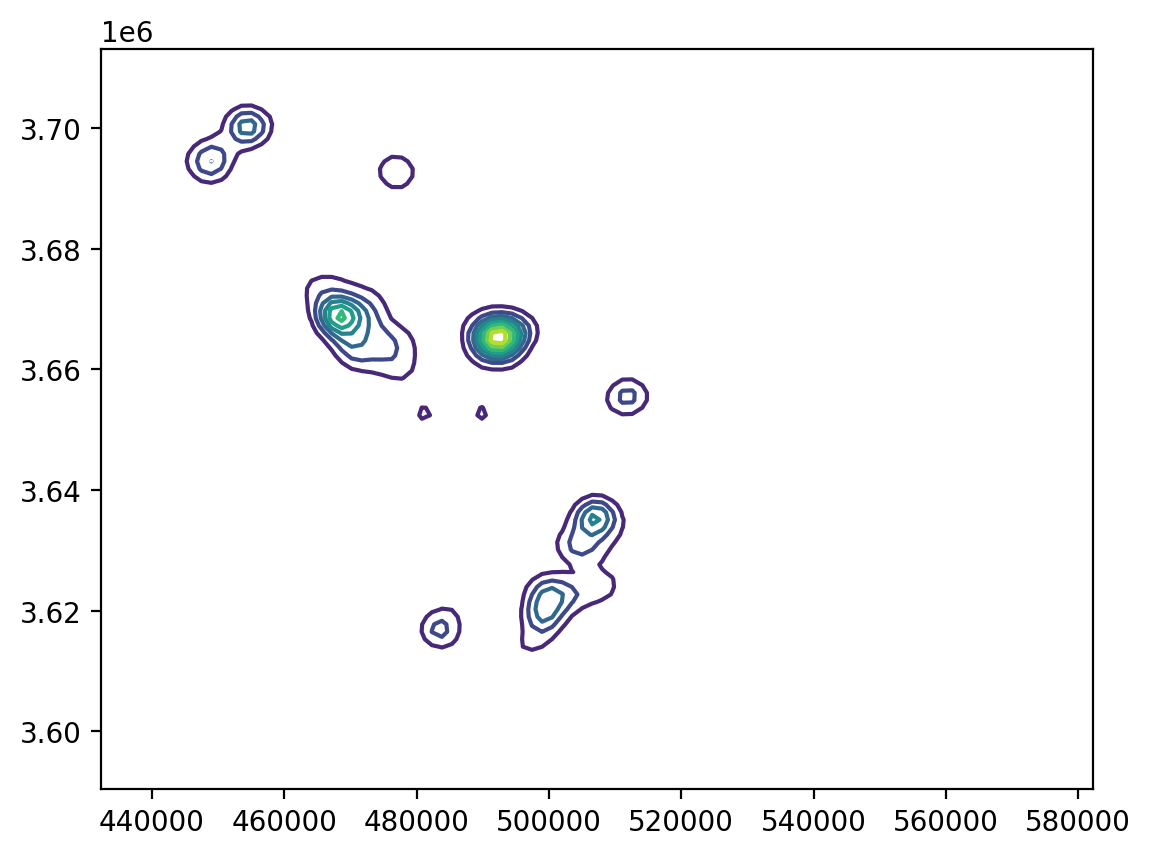

In [9]:
plot_density(bike_collisions, bandwidth=2000)

Plotting a heatmap of these points using a kernel-density estimator can give us a sense for how the events cluster in space, but it ignores the time dimension entirely. We can see that the heatmaps for pedestriand and bicycle collisions are a little different, but it is not clear 

## Global Clustering

The classic Knox statistic is a test for global clustering. It examines whether the pattern of spatio-temporal interaction in the events is random or not.

The two critical parameters for the Knox statistic are `delta` and `tau` which define our neighborhood thresholds in space and time. The `delta` argument is measured in the units of the geodataframe CRS, and `tau` can be measured using any time measurement represented by an integer. 

Here, we'll measure time by the number of days elapsed since the start of data collection. Since the collision date is stored as a string, we can convert to a pandas datetime dtype, then take the difference from the minium date, stored in days (so our time is measured in days).

In [10]:
# convert to datetime
sd_collisions.COLLISION_DATE = pd.to_datetime(
    sd_collisions.COLLISION_DATE, format="%Y%m%d"
)

min_date = sd_collisions.COLLISION_DATE.min()

sd_collisions["time_in_days"] = sd_collisions.COLLISION_DATE.apply(
    lambda x: x - min_date
).dt.days

### Pedestrian Collisions

Here we set delta to `2000` and tau to `30`, meaning our space-time neighborhood is looking for clusters of events that occur within one month and two kilometers of one another.

In [11]:
ped_knox = Knox.from_dataframe(
    ped_collisions, time_col="time_in_days", delta=2000, tau=30
)

In [12]:
ped_knox.p_poisson

5.88418203051333e-15

In [13]:
ped_knox.p_sim

0.01

### Bike Collisions

In [14]:
bike_knox = Knox.from_dataframe(
    bike_collisions, time_col="time_in_days", delta=2000, tau=30
)

In [15]:
bike_knox.p_poisson

0.0

In [16]:
bike_knox.p_sim

0.01

In both the pedestrian and bicycle collision data the p-values (for both analytical and permutation-based inference) are significant, demonstrating evidence of space-time clustering in the collisions. That is, some times and places appear to be more dangerous than others. Using a local Knox statistic, we can start investigating where and when these places might be

## Local Clustering

As with a statistic like Moran's $I$, the Knox statistic can be decomposed into a local version that describes, at an observation level, whether the event at a given location and time is a member of a significant space-time cluster. This can be considered a kind of "hotspot" analysis where the locally significant values identify particular pockets of the study region (and time period) where events are clustered

### Pedestrian Collisions

In [17]:
ped_knox_local = KnoxLocal.from_dataframe(
    ped_collisions, time_col="time_in_days", delta=2000, tau=30
)

As a local statistic, the resulting `KnoxLocal` class no longer has a single $p$-value, but a value for each observation. Since `permutations` is included as a default argument in the KnoxLocal class, p-values from both the analytical and simulation-based inference are available as attributes on the fitted class

In [18]:
ped_knox_local.p_hypergeom

array([1.        , 0.17142085, 1.        , ..., 1.        , 1.        ,
       1.        ])

In [19]:
ped_knox_local.p_sims

array([1.  , 0.15, 1.  , ..., 1.  , 1.  , 1.  ])

Together with the space-time neighbor relationships, we can use these p-values to identify local "hotspots"

In [20]:
ped_knox_local.hotspots()

,pvalue,focal,neighbor,orientation
0,0.05,86,91,lead
1,0.05,86,247,lag
2,0.04,122,128,lag
3,0.03,126,220,lag
4,0.03,126,221,lead
...,...,...,...,...
469,0.01,2473,2271,lead
470,0.01,2473,2276,lag
471,0.01,2473,2468,lead
472,0.03,2478,2479,coincident


Note that every observation in the dataset is assigned a p-value that determines whether it is a significant locus of space-time interaction. But because that significance is determined by *a collection* of events co-occurring inside a space-time neighborhood, each significant observation must *also* have a set of neighboring events that occur within the delta/tau windows.

This means that each event can only become significant if it has space-time neighbors within the neighborhood. The neighbors may be significant but do not need to be. Another way of saying this is that each significant observation must have at least two space-time neighbors, and we can identify the sequence in which the significant cluster occurred

Since we can use either computational/permutation-based inference or an analyical approximation, we can also use the analytical p-values to defined hotspots

In [21]:
ped_knox_local.hotspots(inference="analytic")

,pvalue,focal,neighbor,orientation
0,0.017825,126,220,lag
1,0.017825,126,221,lead
2,0.001876,127,151,lead
3,0.001876,127,534,lag
4,0.001876,127,831,lag
...,...,...,...,...
517,0.000168,2468,2473,lag
518,0.000417,2473,2267,lag
519,0.000417,2473,2271,lead
520,0.000417,2473,2276,lag


And finally we can plot the hotspots to see where they are. By default:

- any observation that is itself significant shows up as red
- any observation that is not itself significant, but is a space-time neighbor of a significant observation shows up as blue
- any observation that is insignificant (at the defined `crit` value) shows up as gray

<Axes: >

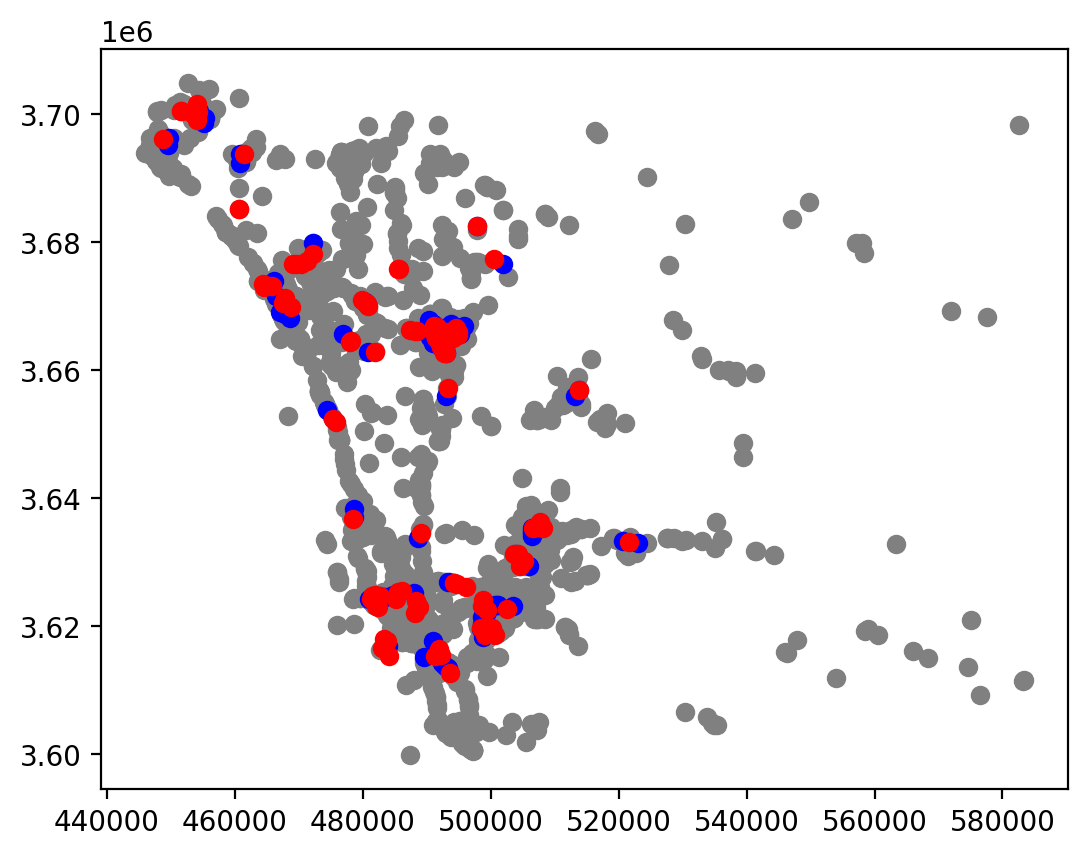

In [22]:
ped_knox_local.plot()  # default critical value is .05

<Axes: >

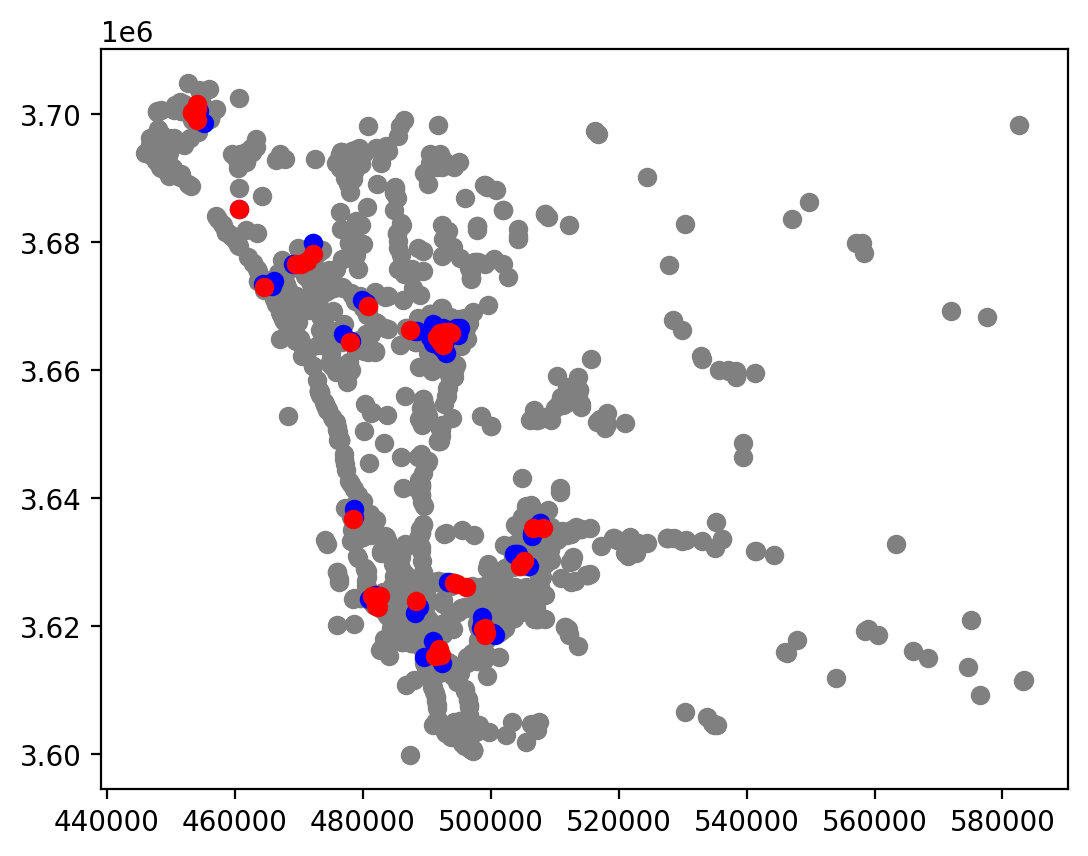

In [23]:
ped_knox_local.plot(crit=0.01, inference='permutation')

For convenience, there is also an interactive version of the hot spot map that uses the same defaults. In the interactive version, an edge (line) is drawn between members of space-time neighborhoods. This makes it easy to identify the "neighborhood" of significant events

In [24]:
ped_knox_local.explore()

### Bike Collisions

In [25]:
bike_knox_local = KnoxLocal.from_dataframe(
    bike_collisions, time_col="time_in_days", delta=2000, tau=30
)

In [26]:
bike_knox_local.explore()

Comparing these maps, it looks like with these `delta` and `tau` parameters, the maps show similarities but also differences. Places like downtown, La Presa, or Escondido can be collision hotspots for both cyclists and pedestrians. But for cyclists, Coronado and Carlsbad show up as particularly dangerous locations. 

Continuing with the analysis, the difference between these two hotspot locations could be because of differences in the local environment, such as poorer cycling infrastructure in Coronado and Carlsbad. But these hotspots could also just reflect that these places have greater numbers of cyclists, and thus, tend to have more frequent collisions.